In [12]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.utils import resample
from scipy.stats import randint
import joblib
import json
from datetime import datetime
import time

# Pastas de saída
MODEL_DIR = "../Treino/models_hierarquico"
RESULTS_DIR = "../Treino/results_hierarquico"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

In [2]:
df = pd.read_csv('../Análise/players_prepared.csv')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
df.head()

,player_positions,overall,potential,age,height_cm,weight_kg,preferred_foot,weak_foot,skill_moves,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,main_position,secondary_position,macro_position,macro_position_secondary,macro_position_enc,main_position_enc,secondary_position_enc,feat_offensive_index,feat_defensive_index,feat_technical_index,feat_speed_index,feat_stamina_strength_ratio,feat_attack_defense_ratio,feat_shooting_passing_ratio,feat_aerial_ability,feat_composure_aggression_ratio,feat_mentality_index,feat_reaction_positioning_avg,feat_vision_passing_combo,feat_bmi,feat_power_index,feat_lightweight_flag,feat_lateral_score,feat_centreback_score,feat_defensive_mid_score,feat_central_mid_score,feat_winger_score,feat_striker_score,feat_attack_minus_defense,feat_pace_minus_shoot
0,"CAM, CM",90,94,22,186,75,1,4,4,80.0,86.0,83.0,90.0,78.0,85.0,66,88,75,90,77,91,73,68,89,91,81,80,83,91,83,86,85,94,80,87,85,82,91,90,74,90,77,79,77,CAM,CM,Midfielder,Midfielder,1,0,3,86.333333,81.5,90.25,80.5,1.175000,1.059305,1.036145,80.0,1.058824,88.25,91.0,89.666667,21.678807,86.25,0,80.000000,80.333333,89.00,90.000000,79.25,83.00,4.833333,-5.5
1,"CM, CDM, RB",89,90,26,182,74,1,4,3,88.0,84.0,84.0,84.0,83.0,85.0,78,80,63,88,78,84,76,69,88,88,84,92,77,89,68,91,82,93,82,91,81,86,86,86,59,84,82,87,86,CM,CDM,Midfielder,Midfielder,1,3,2,84.000000,84.0,86.50,88.0,1.134146,1.000000,1.000000,72.5,1.037037,85.50,87.5,87.333333,22.340297,87.00,0,87.666667,85.000000,88.25,86.000000,84.50,78.75,0.000000,4.0
2,"CDM, RB, CM",89,89,30,177,75,1,4,3,72.0,74.0,89.0,84.0,83.0,79.0,92,68,72,89,69,82,85,79,92,86,75,70,83,89,84,78,77,92,69,83,89,85,78,86,71,86,82,86,85,CDM,RB,Midfielder,Defender,1,2,8,82.333333,81.0,86.25,72.5,1.333333,1.016461,0.831461,74.5,0.966292,83.75,83.5,89.000000,23.939481,79.00,0,84.666667,80.000000,88.00,87.000000,80.25,73.25,1.333333,-1.5
3,"RB, RM",89,90,26,181,73,1,4,4,92.0,79.0,82.0,83.0,82.0,79.0,85,80,71,86,74,82,78,80,73,85,89,95,81,90,78,82,84,95,72,77,77,85,84,78,68,84,82,85,79,RB,RM,Defender,Winger,0,7,9,81.333333,80.5,83.00,92.0,1.319444,1.010352,0.963415,77.5,1.090909,82.75,87.0,79.000000,22.282592,83.25,0,91.666667,80.666667,86.00,82.666667,88.00,76.50,0.833333,13.0
4,CM,87,87,28,175,68,1,4,3,80.0,78.0,84.0,86.0,81.0,76.0,79,77,60,89,80,84,79,67,87,87,82,78,91,91,88,80,75,89,66,79,87,85,84,85,73,88,80,85,80,CM,NaN,Midfielder,NaN,1,3,7,82.666667,78.5,86.75,80.0,1.348485,1.053079,0.928571,67.5,1.011494,85.50,87.5,87.000000,22.204082,77.50,1,82.000000,78.666667,87.00,87.333333,81.25,72.00,4.166667,2.0


In [3]:
df.dtypes

player_positions                    object
overall                              int64
potential                            int64
age                                  int64
height_cm                            int64
weight_kg                            int64
preferred_foot                       int64
weak_foot                            int64
skill_moves                          int64
pace                               float64
shooting                           float64
passing                            float64
dribbling                          float64
defending                          float64
physic                             float64
attacking_crossing                   int64
attacking_finishing                  int64
attacking_heading_accuracy           int64
attacking_short_passing              int64
attacking_volleys                    int64
skill_dribbling                      int64
skill_curve                          int64
skill_fk_accuracy                    int64
skill_long_

In [4]:
# colunas alvo e colunas de feature
targets = ['main_position_enc', 'macro_position_enc', 'secondary_position_enc']
drop_cols = ['player_positions', 'main_position', 'secondary_position',
             'macro_position', 'macro_position_secondary',
             'player_positions'] + targets  # remove targets e strings

X = df.select_dtypes(include=[np.number]).copy()
X = X.drop(columns=[c for c in drop_cols if c in X.columns], errors='ignore')

# targets
y_macro = df['macro_position_enc']
y_main = df['main_position_enc']

# split estratificado por macro_position
X_train, X_test, y_macro_train, y_macro_test, y_main_train, y_main_test = train_test_split(
    X, y_macro, y_main,
    test_size=0.20,
    stratify=y_macro,
    random_state=42
)

print("Shapes:")
print("X_train", X_train.shape, "X_test", X_test.shape)
print("y_macro_train dist:\n", y_macro_train.value_counts())
print("y_main_train dist (sample):\n", y_main_train.value_counts().head())

Shapes:
X_train (13074, 66) X_test (3269, 66)
y_macro_train dist:
 macro_position_enc
0    4893
1    3827
3    2327
2    2027
Name: count, dtype: int64
y_main_train dist (sample):
 main_position_enc
1     2667
10    2027
3     1789
7     1132
2     1131
Name: count, dtype: int64


In [8]:
param_dist = {
    "n_estimators": [200, 300, 500, 800],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ['sqrt', 'log2', 0.3, 0.5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_base = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

rs_macro = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=40,
    scoring='f1_macro',
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

t0 = datetime.now()
print("Iniciando RandomizedSearchCV para rf_macro")
rs_macro.fit(X_train, y_macro_train)
dt = datetime.now() - t0
print("RandomizedSearchCV concluído em", dt)

# salvar resultados e modelo
best_params_macro = rs_macro.best_params_
best_score_macro = float(rs_macro.best_score_)
joblib.dump(rs_macro.best_estimator_, os.path.join(MODEL_DIR, "rf_macro_tuned.pkl"))

with open(os.path.join(RESULTS_DIR, "tuned_macro_metrics.json"), "w") as f:
    json.dump({
        "best_params": best_params_macro,
        "cv_best_score_f1_macro": best_score_macro,
        "tuned_at": datetime.now().isoformat()
    }, f, indent=2)

print("Best params (macro):", best_params_macro)
print("Best CV f1_macro:", best_score_macro)

Iniciando RandomizedSearchCV para rf_macro
Fitting 5 folds for each of 40 candidates, totalling 200 fits
RandomizedSearchCV concluído em 0:28:00.167817
Best params (macro): {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 20}
Best CV f1_macro: 0.8670800241930987


In [9]:
macro_name_map = {0: "Defender", 1: "Midfielder", 2: "Striker", 3: "Winger"}
macro_order_names = ["Defender", "Midfielder", "Striker", "Winger"]

# carregar modelo tunado se existir; caso contrário, usar best_params_macro da última célula
if os.path.exists(os.path.join(MODEL_DIR, "rf_macro_tuned.pkl")):
    rf_macro = joblib.load(os.path.join(MODEL_DIR, "rf_macro_tuned.pkl"))
else:
    try:
        rf_macro = RandomForestClassifier(**best_params_macro, class_weight='balanced', random_state=42, n_jobs=-1)
        rf_macro.fit(X_train, y_macro_train)
    except NameError:
        rf_macro = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
        rf_macro.fit(X_train, y_macro_train)

# prever no holdout
y_macro_pred = rf_macro.predict(X_test)

# classification report: gerar dict e reorganizar para mostrar nomes legíveis na ordem desejada
report_dict = classification_report(y_macro_test, y_macro_pred, output_dict=True, zero_division=0)
ordered = {}
for name in macro_order_names:
    enc = None
    for k,v in macro_name_map.items():
        if v == name:
            enc = k
            break
    key = str(enc)
    if key in report_dict:
        ordered[name] = report_dict[key]

# add aggregates
for agg in ["macro avg", "weighted avg", "accuracy"]:
    if agg in report_dict:
        ordered[agg] = report_dict[agg]
df_report_macro = pd.DataFrame(ordered).T
print("Classification report (macro):\n")
print(df_report_macro)

Classification report (macro):

              precision    recall  f1-score      support
Defender       0.930622  0.954211  0.942269  1223.000000
Midfielder     0.858811  0.845350  0.852027   957.000000
Striker        0.911067  0.909270  0.910168   507.000000
Winger         0.784832  0.764605  0.774587   582.000000
macro avg      0.871333  0.868359  0.869763  3269.000000
weighted avg   0.880611  0.881615  0.881019  3269.000000
accuracy       0.881615  0.881615  0.881615     0.881615


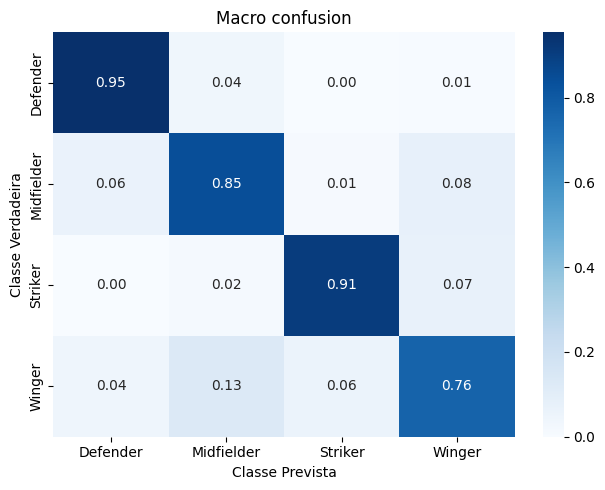

Saved: ../Treino/results_hierarquico\confusion_macro_position.png


In [11]:
labels_enc_order = [k for k,v in sorted(macro_name_map.items(), key=lambda x: x[0])]
cm_macro = confusion_matrix(y_macro_test, y_macro_pred, labels=labels_enc_order, normalize='true')
plt.figure(figsize=(6.5,5))
sns.heatmap(cm_macro, annot=True, fmt=".2f", xticklabels=macro_order_names, yticklabels=macro_order_names, cmap="Blues", linewidths=0)
plt.xlabel("Classe Prevista"); plt.ylabel("Classe Verdadeira"); plt.title("Macro confusion")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "confusion_macro_position.png"), dpi=150)
plt.show()
print("Saved:", os.path.join(RESULTS_DIR, "confusion_macro_position.png"))

In [13]:
# Função para balanceamento
def balance_mix(X_df, y_ser, target_quantile=0.75, random_state=42):
    df_local = X_df.copy()
    df_local["__target__"] = y_ser.values
    counts = df_local["__target__"].value_counts()
    target_n = int(counts.quantile(target_quantile))
    frames = []
    for cls, n in counts.items():
        df_cls = df_local[df_local["__target__"] == cls]
        if n > target_n:
            df_new = resample(df_cls, replace=False, n_samples=target_n, random_state=random_state)
        elif n < target_n:
            df_new = resample(df_cls, replace=True, n_samples=target_n, random_state=random_state)
        else:
            df_new = df_cls
        frames.append(df_new)
    df_bal = pd.concat(frames).sample(frac=1, random_state=random_state).reset_index(drop=True)
    y_bal = df_bal["__target__"].copy()
    X_bal = df_bal.drop(columns="__target__")
    return X_bal, y_bal


In [19]:
allowed_mains_enc = df.groupby('macro_position_enc')['main_position_enc'].unique().apply(list).to_dict()
# converter para int keys/values
allowed_mains_enc = {int(k): [int(v) for v in vs] for k, vs in allowed_mains_enc.items()}

In [17]:
if 'best_params_macro' in globals():
    params_for_mains = best_params_macro.copy()
else:
    params_for_mains = {
        "n_estimators": 300,
        "min_samples_split": 10,
        "min_samples_leaf": 1,
        "max_features": 0.5,
        "max_depth": 20
    }

rf_main_models = {}
for macro_enc, mains_enc in allowed_mains_enc.items():
    mask = (y_macro_train == int(macro_enc))
    X_sub = X_train[mask]
    y_sub = y_main_train[mask]
    print(f"\nMacro enc: {macro_enc} | classes enc: {sorted(y_sub.unique())} | n_samples: {len(y_sub)}")
    
    # balancear localmente
    X_sub_bal, y_sub_bal = balance_mix(X_sub, y_sub, target_quantile=0.75)
    print("  -> after balance n_samples per class:", y_sub_bal.value_counts().to_dict())
    
    rf_m = RandomForestClassifier(
        n_estimators=params_for_mains["n_estimators"],
        max_depth=params_for_mains["max_depth"],
        min_samples_split=params_for_mains["min_samples_split"],
        min_samples_leaf=params_for_mains["min_samples_leaf"],
        max_features=params_for_mains["max_features"],
        random_state=42,
        n_jobs=-1
    )
    rf_m.fit(X_sub_bal, y_sub_bal)
    rf_main_models[int(macro_enc)] = rf_m
    
    model_name = f"rf_main_enc_{macro_enc}.pkl"
    joblib.dump(rf_m, os.path.join(MODEL_DIR, model_name))



Macro enc: 0 | classes enc: [np.int64(1), np.int64(4), np.int64(7)] | n_samples: 4893
  -> after balance n_samples per class: {1: 1899, 4: 1899, 7: 1899}

Macro enc: 1 | classes enc: [np.int64(0), np.int64(2), np.int64(3)] | n_samples: 3827
  -> after balance n_samples per class: {3: 1460, 0: 1460, 2: 1460}

Macro enc: 2 | classes enc: [np.int64(10)] | n_samples: 2027
  -> after balance n_samples per class: {10: 2027}

Macro enc: 3 | classes enc: [np.int64(5), np.int64(6), np.int64(8), np.int64(9)] | n_samples: 2327
  -> after balance n_samples per class: {8: 836, 9: 836, 6: 836, 5: 836}


In [18]:
def predict_hierarchical(X_df):
    macro_preds = rf_macro.predict(X_df)
    main_preds = np.full(len(X_df), -1, dtype=int)
    
    unique_macros = np.unique(macro_preds)
    for M in unique_macros:
        idxs = np.where(macro_preds == M)[0]
        subX = X_df.iloc[idxs]
        model = rf_main_models[M]
        subpred = model.predict(subX)
        main_preds[idxs] = subpred
    return macro_preds, main_preds

In [26]:
custom_order = ["CB", "RB", "LB", "CDM", "CM", "CAM", "RM", "LM", "RW", "LW", "ST"]

mapping_df = df[['main_position_enc', 'main_position']].drop_duplicates().sort_values('main_position_enc')
label_map_enc2name = dict(zip(mapping_df['main_position_enc'], mapping_df['main_position']))
reverse_label_map = {v: int(k) for k, v in label_map_enc2name.items()}

mask_macro_correct = (macro_preds == y_macro_test.values)
print("Macro correct fraction on test:", mask_macro_correct.mean())

Macro correct fraction on test: 0.8816151728357295


In [27]:
if mask_macro_correct.sum() > 0:
    y_main_cond_true = y_main_test.values[mask_macro_correct]
    y_main_cond_pred = main_preds[mask_macro_correct]
    
    # construir ordem de encs seguindo custom_order (só os que aparecem no conjunto)
    # capturar o conjunto de encs presentes no true/pred (condicional)
    present_encs = sorted(list(set(np.unique(y_main_cond_true)) | set(np.unique(y_main_cond_pred))))
    # agora ordenar segundo custom_order quando possível, e manter o restante depois
    ordered_encs = []
    for name in custom_order:
        if name in reverse_label_map:
            enc = reverse_label_map[name]
            if enc in present_encs:
                ordered_encs.append(enc)
    # adicionar encs que estão presentes mas não estavam no custom_order
    for enc in present_encs:
        if enc not in ordered_encs:
            ordered_encs.append(enc)
    # nomes correspondentes (na mesma ordem)
    ordered_names = [label_map_enc2name[enc] for enc in ordered_encs]
    
    # gerar classification_report usando labels + target_names para ter os nomes na ordem desejada
    report_dict = classification_report(
        y_main_cond_true,
        y_main_cond_pred,
        labels=ordered_encs,
        target_names=ordered_names,
        output_dict=True,
        zero_division=0
    )
    df_report = pd.DataFrame(report_dict).T
    print("\nMain (conditional on macro correct) - classification report (named, ordered):")
    print(df_report)
else:
    print("Não há amostras onde o macro foi previsto corretamente no holdout (verifique).")


Main (conditional on macro correct) - classification report (named, ordered):
              precision    recall  f1-score      support
CB             0.956250  0.957746  0.956998   639.000000
RB             0.890459  0.919708  0.904847   274.000000
LB             0.954918  0.917323  0.935743   254.000000
CDM            0.786364  0.694779  0.737740   249.000000
CM             0.726087  0.810680  0.766055   412.000000
CAM            0.751938  0.655405  0.700361   148.000000
RM             0.464646  0.328571  0.384937   140.000000
LM             0.420233  0.724832  0.532020   149.000000
RW             0.320755  0.217949  0.259542    78.000000
LW             0.361111  0.166667  0.228070    78.000000
ST             1.000000  1.000000  1.000000   461.000000
accuracy       0.814018  0.814018  0.814018     0.814018
macro avg      0.693887  0.672151  0.673301  2882.000000
weighted avg   0.813903  0.814018  0.809261  2882.000000


In [28]:
hier_correct = ((macro_preds == y_macro_test.values) & (main_preds == y_main_test.values))
hier_acc = hier_correct.mean()
print("\nHierarchical accuracy (macro AND main correct):", hier_acc)


Hierarchical accuracy (macro AND main correct): 0.7176506576934842


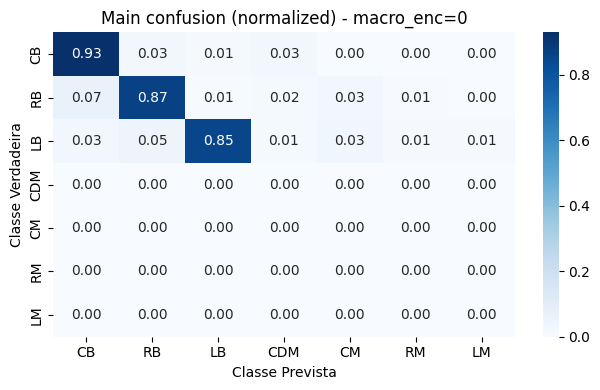

Saved: ../Treino/results_hierarquico\confusion_main_named_macro_enc_0.png


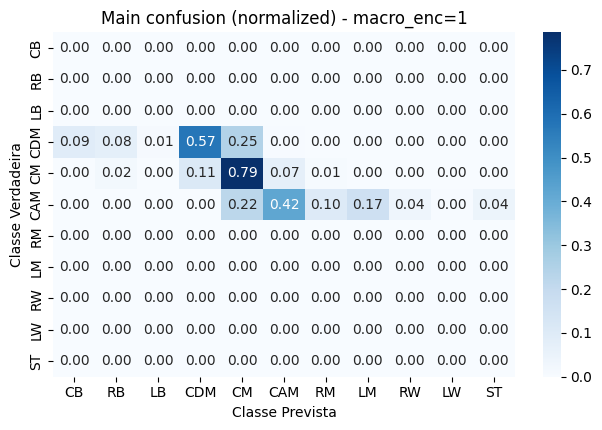

Saved: ../Treino/results_hierarquico\confusion_main_named_macro_enc_1.png


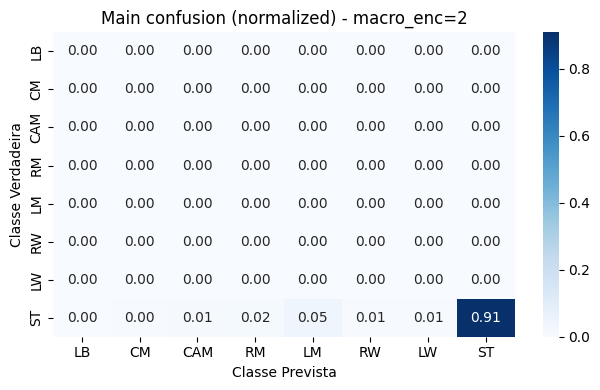

Saved: ../Treino/results_hierarquico\confusion_main_named_macro_enc_2.png


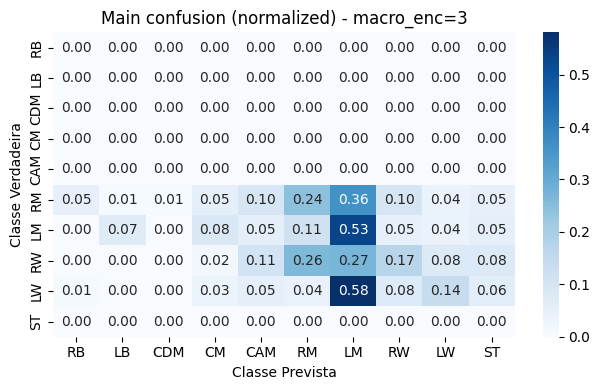

Saved: ../Treino/results_hierarquico\confusion_main_named_macro_enc_3.png


In [30]:
out_df = X_test.reset_index(drop=True).copy()
out_df["true_macro_enc"] = y_macro_test.values
out_df["pred_macro_enc"] = macro_preds
out_df["true_main_enc"] = y_main_test.values
out_df["pred_main_enc"] = main_preds

for M in sorted(allowed_mains_enc.keys()):
    mask_m = (out_df["true_macro_enc"] == M)
    if mask_m.sum() == 0:
        continue
    y_true_main_m = out_df.loc[mask_m, "true_main_enc"].values
    y_pred_main_m = out_df.loc[mask_m, "pred_main_enc"].values
    
    # classes presentes no subconjunto
    classes_m = sorted(list(set(y_true_main_m) | set(y_pred_main_m)))
    
    # ordenar essas classes segundo custom_order quando possível
    ordered_classes_m = []
    # first use custom_order mapping
    for name in custom_order:
        if name in reverse_label_map:
            enc = reverse_label_map[name]
            if enc in classes_m:
                ordered_classes_m.append(enc)
    # append remaining encs not in custom_order
    for enc in classes_m:
        if enc not in ordered_classes_m:
            ordered_classes_m.append(enc)
    
    # display labels (names) in same order
    display_labels = [label_map_enc2name.get(enc, str(enc)) for enc in ordered_classes_m]
    
    cm_m = confusion_matrix(y_true_main_m, y_pred_main_m, labels=ordered_classes_m, normalize='true')
    plt.figure(figsize=(6.5, max(4, 0.4*len(ordered_classes_m))))
    sns.heatmap(cm_m, annot=True, fmt=".2f", xticklabels=display_labels, yticklabels=display_labels, cmap="Blues", linewidths=0)
    plt.title(f"Main confusion (normalized) - macro_enc={M}")
    plt.xlabel("Classe Prevista"); plt.ylabel("Classe Verdadeira")
    plt.tight_layout()
    img_path = os.path.join(RESULTS_DIR, f"confusion_main_named_macro_enc_{M}.png")
    plt.savefig(img_path, dpi=150)
    plt.show()
    print("Saved:", img_path)